In [42]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 1)  # "Ant man" layer
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv6 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv7 = nn.Conv2d(32, 16, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv8 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv9 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv10 = nn.Conv2d(32, 32, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.ln = nn.LayerNorm(32)  # Apply LayerNorm after GAP, matching 32 channels
        self.conv11 = nn.Conv2d(32, 10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool2(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten the output for LayerNorm
        x = self.ln(x)  # Apply LayerNorm
        x = x.view(x.size(0), 32, 1, 1)  # Reshape back for the conv layer
        x = self.conv11(x)
        x = x.view(x.size(0), -1)  # Flatten the output for log_softmax

        return F.log_softmax(x, dim=1)


In [44]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
            Conv2d-2           [-1, 32, 28, 28]           9,248
            Conv2d-3           [-1, 16, 28, 28]             528
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
            Conv2d-6           [-1, 32, 14, 14]           9,248
            Conv2d-7           [-1, 32, 14, 14]           9,248
            Conv2d-8           [-1, 16, 14, 14]             528
         MaxPool2d-9             [-1, 16, 7, 7]               0
           Conv2d-10             [-1, 32, 7, 7]           4,640
           Conv2d-11             [-1, 32, 7, 7]           9,248
           Conv2d-12             [-1, 32, 7, 7]           9,248
AdaptiveAvgPool2d-13             [-1, 32, 1, 1]               0
        LayerNorm-14                   

In [45]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         # Normalize the CIFAR10 dataset with mean and std for each channel (RGB).
                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                     ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                         transforms.ToTensor(),
                         # Normalize using the same values as for the training set.
                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                     ])),
    batch_size=batch_size, shuffle=True, **kwargs)

Files already downloaded and verified


In [46]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # Get predictions and count correct ones
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        # Update progress bar description
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100.*correct/processed:.2f}%')

    # Print training accuracy for the epoch
    print('\nTrain set: Epoch: {}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, correct, len(train_loader.dataset), 100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_indices = []  # List to store indices of misclassified images
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Identify misclassified indices
            misclassified = ~pred.eq(target.view_as(pred))
            idxs = batch_idx * test_loader.batch_size + torch.nonzero(misclassified, as_tuple=False).reshape(-1)
            misclassified_indices.extend(idxs.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    # Print test accuracy
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

    return misclassified_indices

# def display_misclassified_images(misclassified_indices, dataset, num_images=10):
#     if len(misclassified_indices) < num_images:
#         num_images = len(misclassified_indices)
#     fig = plt.figure(figsize=(25, 4))
#     for idx, misclassified_index in enumerate(misclassified_indices[:num_images]):
#         ax = fig.add_subplot(2, num_images/2, idx+1, xticks=[], yticks=[])
#         image, label = dataset[misclassified_index]
#         image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to HxWxC format for displaying
#         ax.imshow(image)
#         ax.set_title(f'Index: {misclassified_index}\nPredicted: {label}')

def display_misclassified_images(misclassified_indices, dataset, num_images=10):
    if len(misclassified_indices) < num_images:
        num_images = len(misclassified_indices)
    num_cols = min(num_images // 2, 5)  # Limiting to 5 columns for better visualization
    fig = plt.figure(figsize=(25, 4))
    for idx, misclassified_index in enumerate(misclassified_indices[:num_images]):
        ax = fig.add_subplot(2, num_cols, idx+1, xticks=[], yticks=[])  # Ensure num_cols is an integer
        image, label = dataset[misclassified_index]
        image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to HxWxC format for displaying
        ax.imshow(image)
        ax.set_title(f'Index: {misclassified_index}\nPredicted: {label}')



Files already downloaded and verified


Loss=2.317626714706421 Batch_id=390 Accuracy=9.97%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]



Train set: Epoch: 1, Accuracy: 4985/50000 (10%)



100%|██████████| 79/79 [00:16<00:00,  4.78it/s]



Test set: Average loss: 2.3067, Accuracy: 1000/10000 (10%)



Loss=2.302070140838623 Batch_id=390 Accuracy=10.14%: 100%|██████████| 391/391 [03:10<00:00,  2.06it/s]



Train set: Epoch: 2, Accuracy: 5069/50000 (10%)



100%|██████████| 79/79 [00:15<00:00,  5.12it/s]



Test set: Average loss: 2.3056, Accuracy: 1000/10000 (10%)



Loss=2.032735586166382 Batch_id=390 Accuracy=15.82%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]



Train set: Epoch: 3, Accuracy: 7911/50000 (16%)



100%|██████████| 79/79 [00:15<00:00,  5.11it/s]



Test set: Average loss: 2.0112, Accuracy: 2025/10000 (20%)



Loss=1.8911793231964111 Batch_id=390 Accuracy=25.32%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s]



Train set: Epoch: 4, Accuracy: 12662/50000 (25%)



100%|██████████| 79/79 [00:15<00:00,  5.01it/s]



Test set: Average loss: 1.8823, Accuracy: 2639/10000 (26%)



Loss=1.6866124868392944 Batch_id=390 Accuracy=30.80%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s]



Train set: Epoch: 5, Accuracy: 15400/50000 (31%)



100%|██████████| 79/79 [00:15<00:00,  5.15it/s]



Test set: Average loss: 1.6942, Accuracy: 3537/10000 (35%)



Loss=1.489426851272583 Batch_id=390 Accuracy=36.02%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]



Train set: Epoch: 6, Accuracy: 18009/50000 (36%)



100%|██████████| 79/79 [00:16<00:00,  4.87it/s]



Test set: Average loss: 1.5997, Accuracy: 3929/10000 (39%)



Loss=1.5773526430130005 Batch_id=390 Accuracy=41.36%: 100%|██████████| 391/391 [03:10<00:00,  2.06it/s]



Train set: Epoch: 7, Accuracy: 20679/50000 (41%)



100%|██████████| 79/79 [00:15<00:00,  5.16it/s]



Test set: Average loss: 1.5423, Accuracy: 4223/10000 (42%)



Loss=1.444011926651001 Batch_id=390 Accuracy=46.08%: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]



Train set: Epoch: 8, Accuracy: 23038/50000 (46%)



100%|██████████| 79/79 [00:16<00:00,  4.89it/s]



Test set: Average loss: 1.4269, Accuracy: 4673/10000 (47%)



Loss=1.368953824043274 Batch_id=390 Accuracy=49.44%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s]



Train set: Epoch: 9, Accuracy: 24719/50000 (49%)



100%|██████████| 79/79 [00:15<00:00,  5.08it/s]



Test set: Average loss: 1.2939, Accuracy: 5227/10000 (52%)



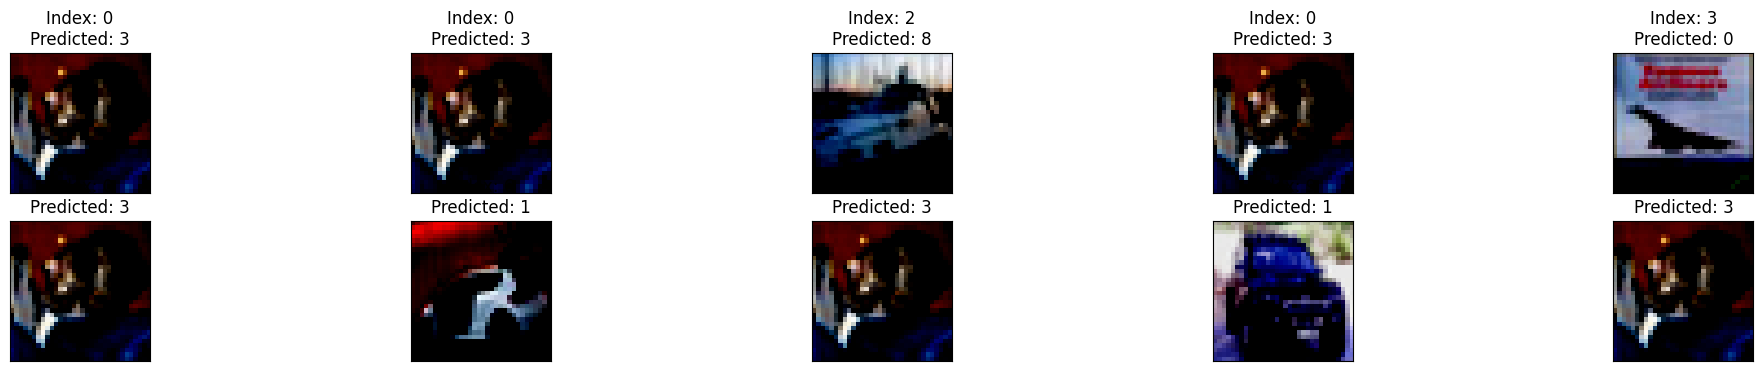

In [47]:
import torchvision
import torchvision.transforms as transforms
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)
    x= test(model, device, test_loader)
display_misclassified_images(x, testset, num_images=10)


